In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.special import logsumexp
import pymc3 as pm
import theano.tensor as TT
import accuracy_analysis as aa
from corner import corner

In [2]:
def make_sample(N, f_M, r_Ms, r_Is, seed=None):
    np.random.seed(seed)
    true_gals = np.random.choice([0,1], size=N, p=[1-f_M, f_M])
    f_M_sample = true_gals.sum()/N
    N_true = true_gals.sum()
    
    n = len(r_Ms)
    

    # Matrix of classifier answers
    m = np.zeros((n, N), dtype='int')
    for i in range(n):
        for j in range(N):
            if true_gals[j] == 0:
                m[i,j] = np.random.choice([0,1], p=[r_Is[i], 1-r_Is[i]])
            elif true_gals[j] == 1:
                m[i,j] = np.random.choice([0,1], p=[1-r_Ms[i], r_Ms[i]])

    
    return N_true, m, true_gals

In [3]:
def make_flat(observations):
    n_cfers, n_obj = observations.shape
    obs_flat = observations.ravel()
    
    cfer_ids = np.zeros([n_cfers, n_obj], dtype='int')
    for i in range(n_cfers):
        cfer_ids[i] = i
    cfer_ids = cfer_ids.ravel()
    
    obj_ids = np.zeros([n_cfers, n_obj], dtype='int')
    for j in range(n_obj):
        obj_ids[:, j] = j
    obj_ids = obj_ids.ravel()
    
    return obs_flat, obj_ids, cfer_ids

In [4]:
def get_beta_pars(truths, observed):
    t0 = (truths==0)
    t1 = (truths==1)
    o0 = (observed==0)
    o1 = (observed==1)
    
    a_00 = np.count_nonzero(t0 & o0, axis=1) + 1
    b_00 = np.count_nonzero(t0 & o1, axis=1) + 1
    b_11 = np.count_nonzero(t1 & o0, axis=1) + 1
    a_11 = np.count_nonzero(t1 & o1, axis=1) + 1
    
    return a_00, b_00, a_11, b_11


In [5]:
def get_chains(obs, obs_train, true_train):
    '''
    these arrays are n_galaxies x n_classifiers, and are 0 for isolated, 1 for merger.
    '''
    obs_classes, obj_ids, cfer_ids = make_flat(obs)
    a_00, b_00, a_11, b_11 = get_beta_pars(true_train, obs_train) 
    
    n_cfers, n_obj = obs.shape
    
    with pm.Model() as explicit_model:
        f_M  = pm.Beta('fM', alpha=0.5, beta=0.5)
        r_Is = pm.Beta('rI', alpha=a_00, beta=b_00, shape=n_cfers)
        r_Ms = pm.Beta('rM', alpha=a_11, beta=b_11, shape=n_cfers)
    
        #the "real" data
        true_class = pm.Bernoulli('true_class', f_M, shape=n_obj)
        N_M_true = pm.Deterministic('N_M', TT.sum(true_class))
        p_obs_1 = TT.switch(TT.eq(true_class[obj_ids], 1), r_Ms[cfer_ids], 1-r_Is[cfer_ids])
        observed = pm.Bernoulli('observed', p_obs_1, observed=obs_classes)

    with explicit_model:
        trace = pm.sample(draws=5000)

    return trace.get_values('fM'), trace.get_values('rI'), trace.get_values('rM'), trace.get_values('true_class')

In [6]:
from scipy.special import beta as Beta

def make_obs(n_cfers=2, seed=0, f_M_true=0.2, f_M_train=0.5, n_obj=200, n_train=20):
    np.random.seed(seed)
    cfer_probs = np.random.uniform(low=0.5, high=0.9, size=n_cfers*2).reshape(-1,2)

    r_Is = cfer_probs[:, 0]
    r_Ms = cfer_probs[:, 1]

    true, obs, true_samp = make_sample(n_obj, f_M_true, r_Ms, r_Is, seed=1234)

    true_train, obs_train, true_samp_train = make_sample(n_train, f_M_train, r_Ms, r_Is, seed=123)
    return obs, true, obs_train, true_train, true_samp

def analyze_sim_sample(obs, obs_train, true_train, true_samp):

    f_Ms, r_Is, r_Ms, classif = get_chains(obs, obs_train, true_train)

    plt.figure()

    plt.hist(f_Ms, bins=np.linspace(0,1,101), density=True)
    plt.xlabel(r'$f_M$')
    print(np.percentile(f_Ms, [16, 50, 84]))
    n_cfers, n_obj = obs.shape
    
    # Binomial distribution assuming that all of the galaxies were classified perfectly
    # Fundamental limit to which a sample's merger fraction can be determined.
    #alpha=int(np.median(f_Ms)*n_obj)+1
    #beta = n_obj-true+1
    #p = np.linspace(0, 0.5, 1000)
    #plt.plot(p,p**(alpha-1)*(1-p)**(beta-1)/Beta(alpha,beta))
    
    p_Ms = np.zeros((1000, n_obj))
    p_Ms = []
    for k in np.random.choice(np.arange(len(f_Ms)), size=1000):
        for j in range(n_obj):
            num = 1
            den_I = 1
            den_M = 1
            for i in range(n_cfers):
                if obs[i,j] == 0:
                    num *= (1-r_Ms[k,i])
                    den_M *= (1-r_Ms[k,i])
                    den_I *= r_Is[k,i]
                else:
                    num *= r_Ms[k,i]
                    den_M *= r_Ms[k,i]
                    den_I *= (1-r_Ms[k,i])
            p_Ms.append(num*f_Ms[k]/(den_M*f_Ms[k]+den_I*(1-f_Ms[k])))
    p_Ms = np.array(p_Ms)
    p_Ms = p_Ms.reshape(-1, n_obj)
    
    inds = ()
    plt.figure(figsize=(12,4))
    yll, mu, yul = np.percentile(p_Ms, [16,50,68], axis=0)
    inds = (true_samp == 0)
    plt.errorbar(np.arange(n_obj)[inds], mu[inds], yerr=[mu[inds]-yll[inds], yul[inds]-mu[inds]], fmt='.')
    inds = (true_samp == 1)
    plt.errorbar(np.arange(n_obj)[inds], mu[inds], yerr=[mu[inds]-yll[inds], yul[inds]-mu[inds]], fmt='.')
    plt.xlabel('Galaxy index')
    plt.ylabel(r'$p_M$')
    
    p_Ms = np.zeros((1000, n_obj))
    p_Ms = []
    for k in np.random.choice(np.arange(len(f_Ms)), size=1000):
        for j in range(n_obj):
            num = 1
            den_I = 1
            den_M = 1
            for i in range(n_cfers):
                if obs[i,j] == 0:
                    num *= (1-r_Ms[k,i])
                    den_M *= (1-r_Ms[k,i])
                    den_I *= r_Is[k,i]
                else:
                    num *= r_Ms[k,i]
                    den_M *= r_Ms[k,i]
                    den_I *= (1-r_Ms[k,i])
            p_Ms.append(num/(den_M+den_I))
    p_Ms = np.array(p_Ms)
    p_Ms = p_Ms.reshape(-1, n_obj)

    plt.figure(figsize=(12,4))
    yll, mu, yul = np.percentile(p_Ms, [16,50,68], axis=0)
    inds = (true_samp == 0)
    plt.errorbar(np.arange(n_obj)[inds], mu[inds], yerr=[mu[inds]-yll[inds], yul[inds]-mu[inds]], fmt='.')
    inds = (true_samp == 1)
    plt.errorbar(np.arange(n_obj)[inds], mu[inds], yerr=[mu[inds]-yll[inds], yul[inds]-mu[inds]], fmt='.')
    plt.xlabel('Galaxy index')
    plt.ylabel(r'$p_M$')
    plt.title('Flat prior')
    return f_Ms, r_Is, r_Ms, classif

In [17]:
def analyze_sample(obs, obs_train, true_train):

    f_Ms, r_Is, r_Ms, classif = get_chains(obs, obs_train, true_train)

    plt.figure()

    plt.hist(f_Ms, bins=np.linspace(0,1,101), density=True)
    plt.xlabel(r'$f_M$')
    print(np.percentile(f_Ms, [16, 50, 84]))
    n_cfers, n_obj = obs.shape
    
    # Binomial distribution assuming that all of the galaxies were classified perfectly
    # Fundamental limit to which a sample's merger fraction can be determined.
    #alpha=int(np.median(f_Ms)*n_obj)+1
    #beta = n_obj-true+1
    #p = np.linspace(0, 0.5, 1000)
    #plt.plot(p,p**(alpha-1)*(1-p)**(beta-1)/Beta(alpha,beta))
    
    p_Ms = np.zeros((1000, n_obj))
    p_Ms = []
    for k in np.random.choice(np.arange(len(f_Ms)), size=1000):
        for j in range(n_obj):
            num = 1
            den_I = 1
            den_M = 1
            for i in range(n_cfers):
                if obs[i,j] == 0:
                    num *= (1-r_Ms[k,i])
                    den_M *= (1-r_Ms[k,i])
                    den_I *= r_Is[k,i]
                else:
                    num *= r_Ms[k,i]
                    den_M *= r_Ms[k,i]
                    den_I *= (1-r_Ms[k,i])
            p_Ms.append(num*f_Ms[k]/(den_M*f_Ms[k]+den_I*(1-f_Ms[k])))
    p_Ms = np.array(p_Ms)
    p_Ms = p_Ms.reshape(-1, n_obj)
    
    inds = ()
    plt.figure(figsize=(12,4))
    yll, mu, yul = np.percentile(p_Ms, [16,50,68], axis=0)
    plt.errorbar(np.arange(n_obj), mu, yerr=[mu-yll, yul-mu], fmt='.')
    plt.xlabel('Galaxy index')
    plt.ylabel(r'$p_M$')
    
    p_Ms = np.zeros((1000, n_obj))
    p_Ms = []
    for k in np.random.choice(np.arange(len(f_Ms)), size=1000):
        for j in range(n_obj):
            num = 1
            den_I = 1
            den_M = 1
            for i in range(n_cfers):
                if obs[i,j] == 0:
                    num *= (1-r_Ms[k,i])
                    den_M *= (1-r_Ms[k,i])
                    den_I *= r_Is[k,i]
                else:
                    num *= r_Ms[k,i]
                    den_M *= r_Ms[k,i]
                    den_I *= (1-r_Ms[k,i])
            p_Ms.append(num/(den_M+den_I))
    p_Ms = np.array(p_Ms)
    p_Ms = p_Ms.reshape(-1, n_obj)

    plt.figure(figsize=(12,4))
    yll, mu, yul = np.percentile(p_Ms, [16,50,68], axis=0)
    plt.errorbar(np.arange(n_obj), mu, yerr=[mu-yll, yul-mu], fmt='.')
    plt.xlabel('Galaxy index')
    plt.ylabel(r'$p_M$')
    plt.title('Flat prior')
    return f_Ms, r_Is, r_Ms, classif

In [8]:
obs, true, obs_train, true_train, true_samp = make_obs(n_cfers=14, n_obj=193, n_train=41)
# Here we are simulating a fake set of observations
# First, there are the true sets of observation, obs.
# Second, there is the true total number of mergers, true. Should not be used for analysis.
# Third, obs_train, the observations of the mock galaxies.
# Fourth, true_train, the true total number of mergers in the training sample
# Finally, there is true_samp, the actual set of mergers in the real sample.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [rM, rI, fM]
>BinaryGibbsMetropolis: [true_class]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [05:35<00:00, 65.50draws/s] 


[0.16357291 0.19377801 0.22649738]


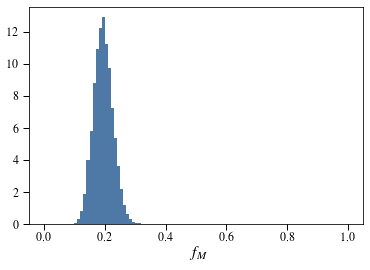

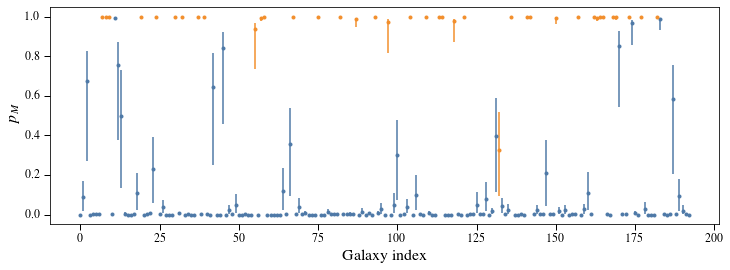

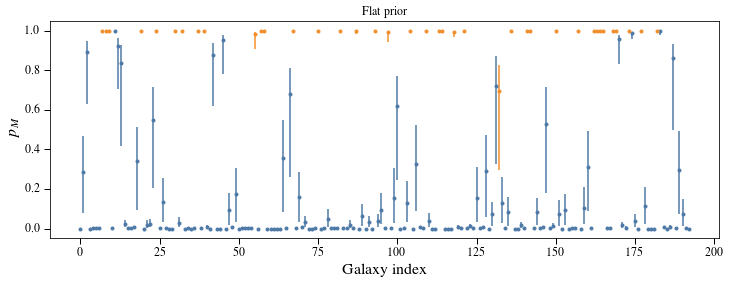

In [9]:
f_Ms, r_Is, r_Ms, classif = analyze_sim_sample(obs, obs_train, true_train, true_samp)

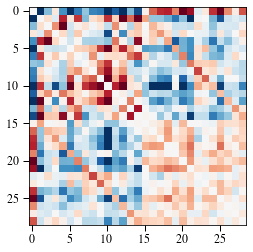

In [10]:
#f_Ms, r_Is, r_Ms, classif
bla = np.hstack((f_Ms[:,None], r_Ms, r_Is))
C = np.cov(bla.T)

diag = np.diag(C)
rho = C/np.outer(diag,diag)**0.5
plt.imshow(rho-np.eye(rho.shape[1]), vmin=-0.1, vmax=0.1, cmap='RdBu_r')

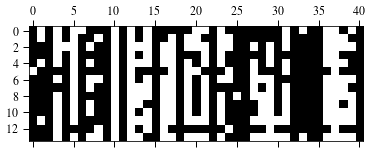

In [11]:
#for mock data with real classifiers
import pandas as pd 
df_full = pd.read_hdf('df_full_04272020.hdf5','table')
df_mock = pd.read_csv('mock_question_key.csv')



merger = ['MaM', 'MaD', 'MiM']

not_fake_indexes = df_mock.mock_question_num[df_mock.type != 'f'].sort_values().values

survey_index = df_full.set_type[not_fake_indexes].index
obs_train = np.zeros((14, len(survey_index)))
for i in range(len(survey_index)):
    k = survey_index[i]
    s = df_full.loc[k][2::2]
    for j in range(14):
        if s[j] in merger:
             obs_train[j,i] = 1

plt.spy(obs_train)
inds = np.arange(41)
true_samp = np.zeros(41)

merger = ['m']
for i in range(len(survey_index)):
    k = survey_index[i]
    s = df_mock.type[df_mock.mock_question_num == k]
    if s.values in merger:
        true_samp[i] = 1
                
true_train = int(sum(true_samp))

In [12]:
k = 0
for i in range(len(df_full.set_type)):
    if i in survey_index:
        k += 1
        
merger = ['MaM', 'MaD', 'MiM']

obs = np.zeros((14, len(df_full.set_type)))
k = 0
for i in range(1, len(df_full.set_type)):
    s = df_full.loc[i][2::2]
    for j in range(14):
        if s[j] in merger:
            obs[j,i] = 1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [rM, rI, fM]
>BinaryGibbsMetropolis: [true_class]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [05:47<00:00, 63.24draws/s] 


[0.4579948  0.49493909 0.53137914]


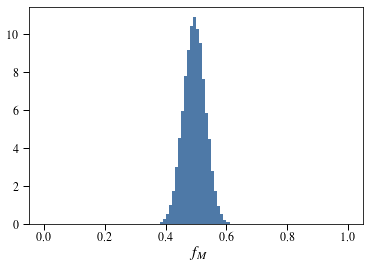

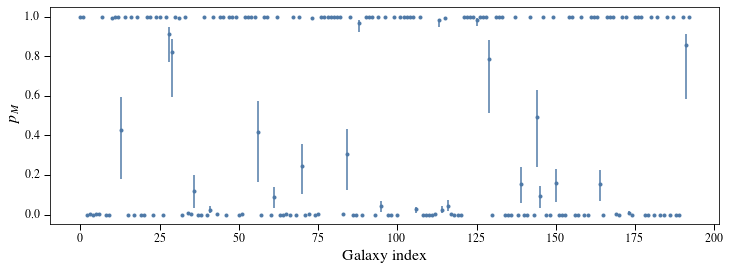

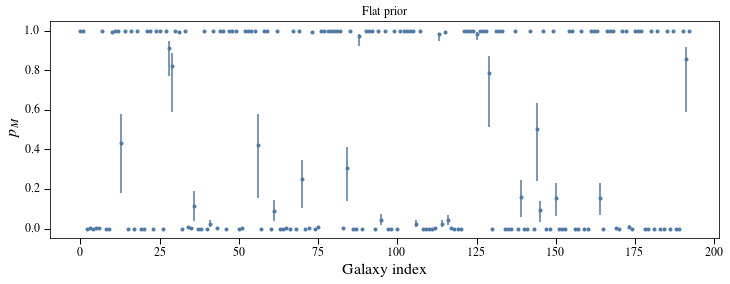

In [18]:
f_Ms, r_Is, r_Ms, classif = analyze_sample(obs, obs_train, true_train)

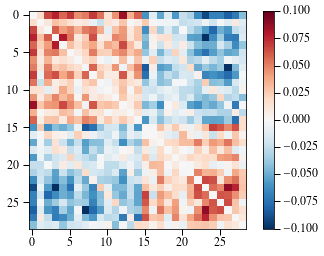

In [19]:
#f_Ms, r_Is, r_Ms, classif
bla = np.hstack((f_Ms[:,None], r_Ms, r_Is))
C = np.cov(bla.T)

diag = np.diag(C)
rho = C/np.outer(diag,diag)**0.5
plt.imshow(rho-np.eye(rho.shape[1]), vmin=-0.1, vmax=0.1, cmap='RdBu_r')
plt.colorbar()

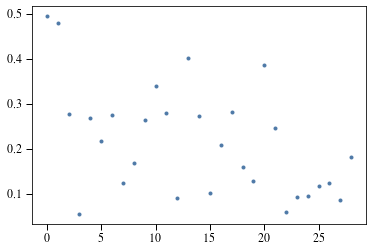

In [20]:
plt.plot(bla.mean(axis=0), '.')

In [21]:
true_train

24